In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import seaborn
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.signal import periodogram
import data
import numpy as np
import requests

In [3]:
df = pd.read_csv("../datasets/energy_dataset.csv")



columns = ["generation hydro pumped storage aggregated", "forecast wind offshore eday ahead", "generation fossil coal-derived gas", "generation wind offshore", "generation marine", "generation geothermal",
"generation fossil peat","generation fossil oil shale","forecast solar day ahead","forecast wind onshore day ahead"]
df = df.drop(columns,axis = 1)


df["time"] = pd.to_datetime(df["time"], utc = True)
df.fillna(df.interpolate(method="linear"),inplace=True)
df = df.set_index('time').asfreq("1H")


df["year"] = df.index.year
df["month"] = df.index.month
df["week"] = df.index.weekday


df.describe()



,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,generation solar,generation waste,generation wind onshore,total load forecast,total load actual,price day ahead,price actual,year,month,week
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,...,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,383.531343,448.094570,5622.700647,4256.531271,298.342417,475.582706,972.201902,2605.534123,6263.483430,60.226030,...,1432.818546,269.418692,5464.980450,28712.129962,28698.281385,49.874341,57.884023,2016.499544,6.522930,3.002110
std,85.346266,354.618269,2201.510984,1961.988937,52.519927,792.312704,400.712304,1835.175078,840.272333,20.238792,...,1679.961733,50.218423,3213.586296,4594.100854,4575.828854,14.618900,14.204083,1.117795,3.448752,2.000484
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,18105.000000,18041.000000,2.060000,9.330000,2014.000000,1.000000,0.000000
25%,333.000000,0.000000,4126.000000,2527.000000,263.000000,0.000000,637.000000,1078.000000,5759.000000,53.000000,...,71.000000,240.000000,2933.000000,24793.750000,24807.000000,41.490000,49.347500,2016.000000,4.000000,1.000000
50%,367.000000,509.000000,4969.500000,4475.000000,300.000000,68.000000,906.000000,2165.000000,6564.000000,57.000000,...,616.000000,279.000000,4849.500000,28906.000000,28902.000000,50.520000,58.020000,2016.000000,7.000000,3.000000
75%,433.000000,757.000000,6429.000000,5839.000000,330.000000,616.000000,1250.000000,3758.000000,7025.000000,80.000000,...,2579.000000,310.000000,7399.500000,32263.250000,32194.250000,60.530000,68.010000,2017.000000,10.000000,5.000000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,2000.000000,9728.000000,7117.000000,106.000000,...,5792.000000,357.000000,17436.000000,41390.000000,41015.000000,101.990000,116.800000,2018.000000,12.000000,6.000000


In [14]:
#Find missing timestamps
from datetime import timedelta,datetime
new_df = pd.DataFrame(
    pd.date_range(
        start=df.index.min(), 
        end=df.index.max(),
        freq='H'
    ).difference(df.index)
)
missing_columns = [col for col in df.columns if col!="time"]

# add null data
new_df[missing_columns] = np.nan

# fix column names
new_df.columns = ["time"] + missing_columns

print(new_df)


Empty DataFrame
Columns: [time, generation biomass, generation fossil brown coal/lignite, generation fossil gas, generation fossil hard coal, generation fossil oil, generation hydro pumped storage consumption, generation hydro run-of-river and poundage, generation hydro water reservoir, generation nuclear, generation other, generation other renewable, generation solar, generation waste, generation wind onshore, total load forecast, total load actual, price day ahead, price actual, year, month, week]
Index: []

[0 rows x 22 columns]


In [ ]:
#rename columns if needed

columns = []
for name in df.columns:

    if "generation" in name:
        renamed =  name.replace("generation","")
        df = df.rename(columns = {name: renamed})

df.columns

In [4]:
"""splitting data"""
print(df.columns)
x = df.drop("total load actual",axis = 1)
y = df["total load actual"]
tss = TimeSeriesSplit(n_splits=3)
print(tss)
for train,test in tss.split(df):
    trainx, testx = x.iloc[train,:], x.iloc[test,:]
    trainy, testy = y.iloc[train], y.iloc[test]

print(len(testx))
print(len(trainx))


Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual', 'year', 'month',
       'week'],
      dtype='object')
TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)
8766
26298


In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [5]:
#0:26298
dfdaily = df.resample("D").mean()
dfdaily.head

<bound method NDFrame.head of                            generation biomass  \
time                                            
2014-12-31 00:00:00+00:00          447.000000   
2015-01-01 00:00:00+00:00          425.208333   
2015-01-02 00:00:00+00:00          389.875000   
2015-01-03 00:00:00+00:00          436.875000   
2015-01-04 00:00:00+00:00          396.375000   
...                                       ...   
2018-12-27 00:00:00+00:00          304.666667   
2018-12-28 00:00:00+00:00          316.291667   
2018-12-29 00:00:00+00:00          288.500000   
2018-12-30 00:00:00+00:00          275.333333   
2018-12-31 00:00:00+00:00          296.391304   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 00:00:00+00:00                            329.000000   
2015-01-01 00:00:00+00:00                            243.708333   
2015-01-02 00:00:00+00:00                              0.000000 

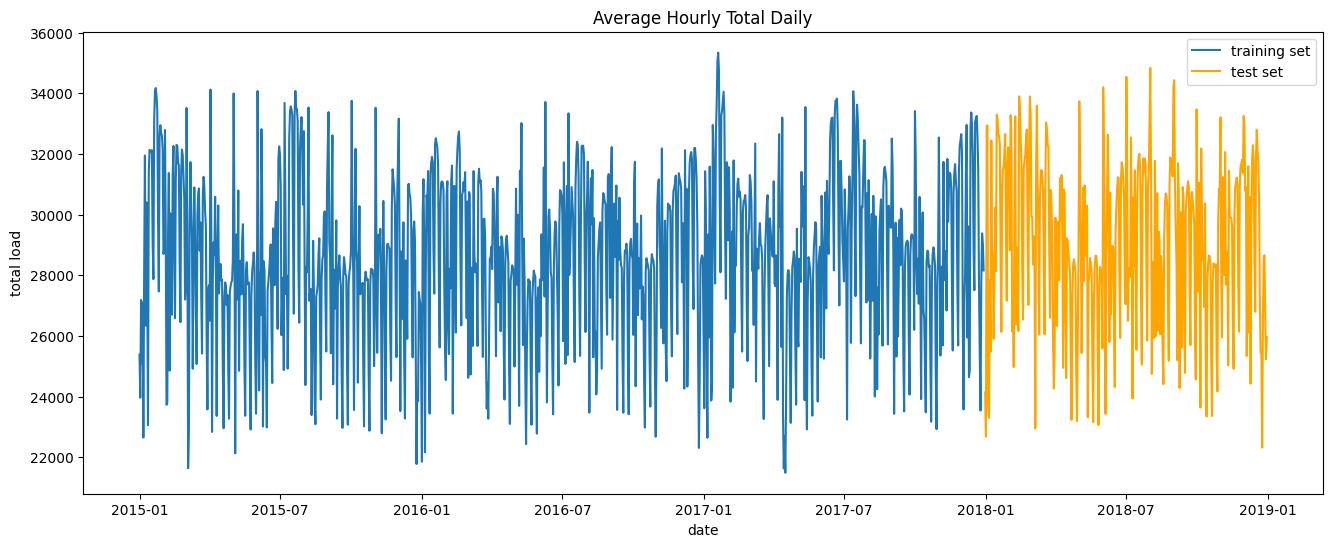

In [20]:
#daily average load plot
def daily_plot():
    plt.figure(figsize=(16, 6))
    plt.tick_params(axis='x')
    plt.tick_params(axis='y')
    plt.xlabel("date")
    plt.ylabel("total load")
    plt.title("Average Hourly Total Daily")
    plt.plot(dfdaily.index[0:1095], dfdaily["total load actual"].iloc[0:1095])
    plt.plot(dfdaily.index[1096:], dfdaily["total load actual"].iloc[1096:],color = "orange")
    plt.legend(['training set','test set'])


daily_plot()

In [3]:
#create lag feature
dfcopy = pd.DataFrame()
#dfcopy["lag"] = df["total load actual"].shift(1)

for x in range(6):
    name = "lag"+str(x)
    dfcopy[name] = df["total load actual"].shift(x+1)
print(dfcopy.head)
print(len(df["total load actual"]))


<bound method NDFrame.head of                               lag0     lag1     lag2     lag3     lag4  \
time                                                                     
2014-12-31 23:00:00+00:00      NaN      NaN      NaN      NaN      NaN   
2015-01-01 00:00:00+00:00  25385.0      NaN      NaN      NaN      NaN   
2015-01-01 01:00:00+00:00  24382.0  25385.0      NaN      NaN      NaN   
2015-01-01 02:00:00+00:00  22734.0  24382.0  25385.0      NaN      NaN   
2015-01-01 03:00:00+00:00  21286.0  22734.0  24382.0  25385.0      NaN   
...                            ...      ...      ...      ...      ...   
2018-12-31 18:00:00+00:00  29592.0  26738.0  26449.0  27009.0  27988.0   
2018-12-31 19:00:00+00:00  30653.0  29592.0  26738.0  26449.0  27009.0   
2018-12-31 20:00:00+00:00  29735.0  30653.0  29592.0  26738.0  26449.0   
2018-12-31 21:00:00+00:00  28071.0  29735.0  30653.0  29592.0  26738.0   
2018-12-31 22:00:00+00:00  25801.0  28071.0  29735.0  30653.0  29592.0   

       

Index(['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'total load actual'], dtype='object')
                       lag0      lag1      lag2      lag3      lag4      lag5  \
lag0               1.000000  0.951241  0.833415  0.676669  0.506223  0.343406   
lag1               0.951241  1.000000  0.951247  0.833432  0.676691  0.506239   
lag2               0.833415  0.951247  1.000000  0.951251  0.833438  0.676695   
lag3               0.676669  0.833432  0.951251  1.000000  0.951251  0.833438   
lag4               0.506223  0.676691  0.833438  0.951251  1.000000  0.951252   
lag5               0.343406  0.506239  0.676695  0.833438  0.951252  1.000000   
total load actual  0.951235  0.833394  0.676635  0.506185  0.343377  0.205496   

                   total load actual  
lag0                        0.951235  
lag1                        0.833394  
lag2                        0.676635  
lag3                        0.506185  
lag4                        0.343377  
lag5                    

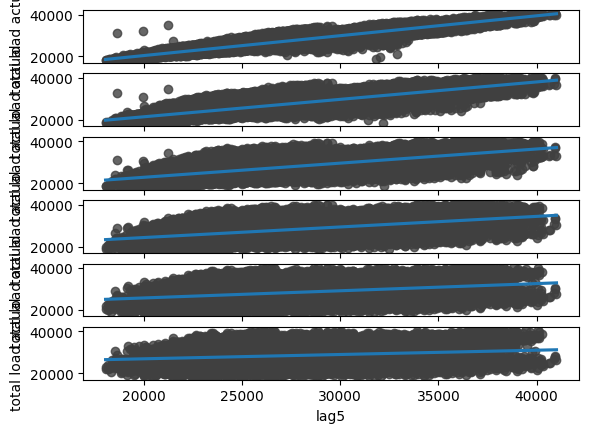

In [7]:
#relationship between target and lagged target, exploring serial dependance in the dataset
#dfcopy = dfcopy.merge([dfcopy,df["total load actual"]])
dfcopy = pd.concat([dfcopy,df["total load actual"]],axis = 1)
dfcopy = dfcopy.dropna()
print(dfcopy.columns)
print(dfcopy.corr())
print(dfcopy.head)

fig, axs = plt.subplots(6)
for x in range(6):
    seaborn.regplot(x=dfcopy["lag"+str(x)], y=dfcopy["total load actual"], data=dfcopy, ci=None, scatter_kws=dict(color='0.25'),ax=axs[x])

from statsmodels.graphics.tsaplots import plot_pacf

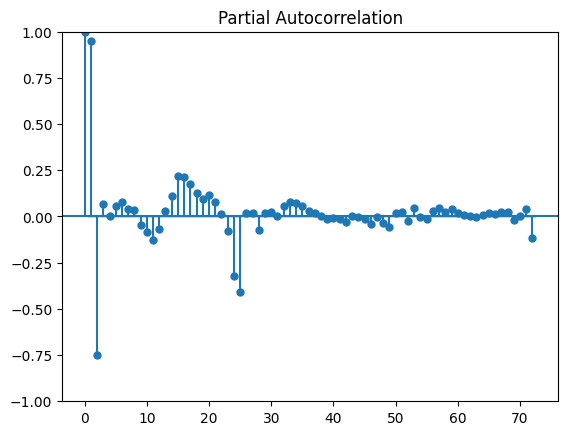

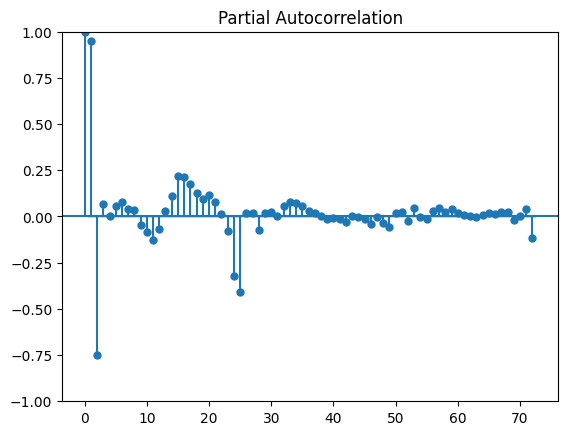

In [8]:
plot_pacf(dfcopy["total load actual"], lags=72)

<bound method NDFrame.head of                            const    trend
time                                     
2014-12-31 23:00:00+00:00    1.0      1.0
2015-01-01 00:00:00+00:00    1.0      2.0
2015-01-01 01:00:00+00:00    1.0      3.0
2015-01-01 02:00:00+00:00    1.0      4.0
2015-01-01 03:00:00+00:00    1.0      5.0
...                          ...      ...
2017-12-31 12:00:00+00:00    1.0  26294.0
2017-12-31 13:00:00+00:00    1.0  26295.0
2017-12-31 14:00:00+00:00    1.0  26296.0
2017-12-31 15:00:00+00:00    1.0  26297.0
2017-12-31 16:00:00+00:00    1.0  26298.0

[26298 rows x 2 columns]>

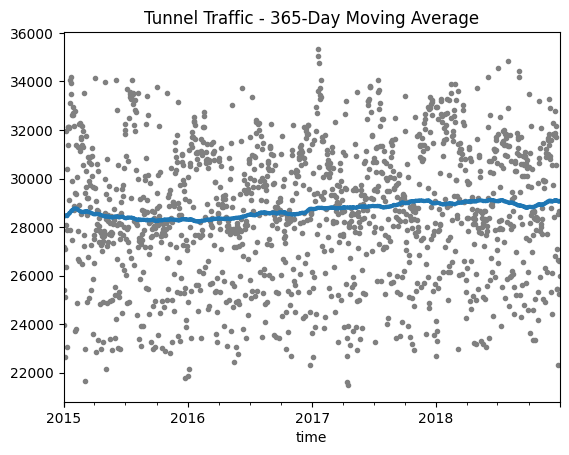

In [26]:
#trend shown using moving average plot, exploring time dependance in the dataset
dftarget = dfdaily["total load actual"]

moving_average = dftarget.rolling(window = 365, center = True, min_periods=183).mean()
ax = dftarget.plot(style=".", color="grey")
moving_average.plot(ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,)


from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=trainx.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
X = dp.in_sample()
X.head


In [28]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
model.fit(X,trainy)
y_pred = pd.Series(model.predict(X), index = X.index)

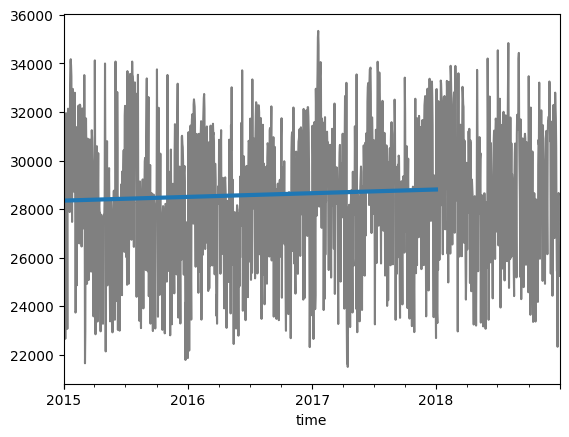

In [29]:
ax = dftarget.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

<AxesSubplot: >

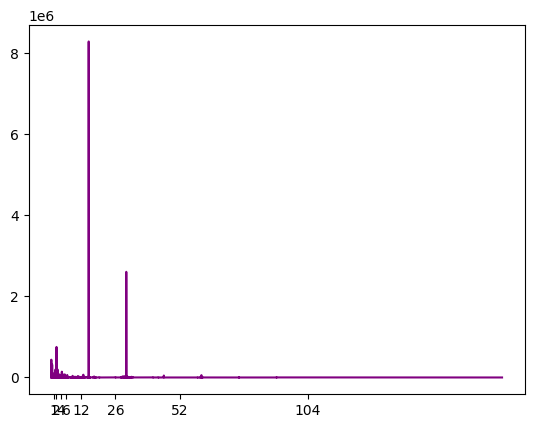

In [21]:
#seasonality
def feature_plot(data,feature,period):
    plt.figure(figsize=(8, 6))
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')
    plt.plot(data[period], data[feature])

#feature_plot(df,"total load actual","year")

#periodogram
def plot_periodogram():
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        df["total load actual"],
        fs=fs,
        detrend="linear",
        window="boxcar",
        scaling='spectrum',
    )
    
    _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    #ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])

    return ax
 
plot_periodogram()    


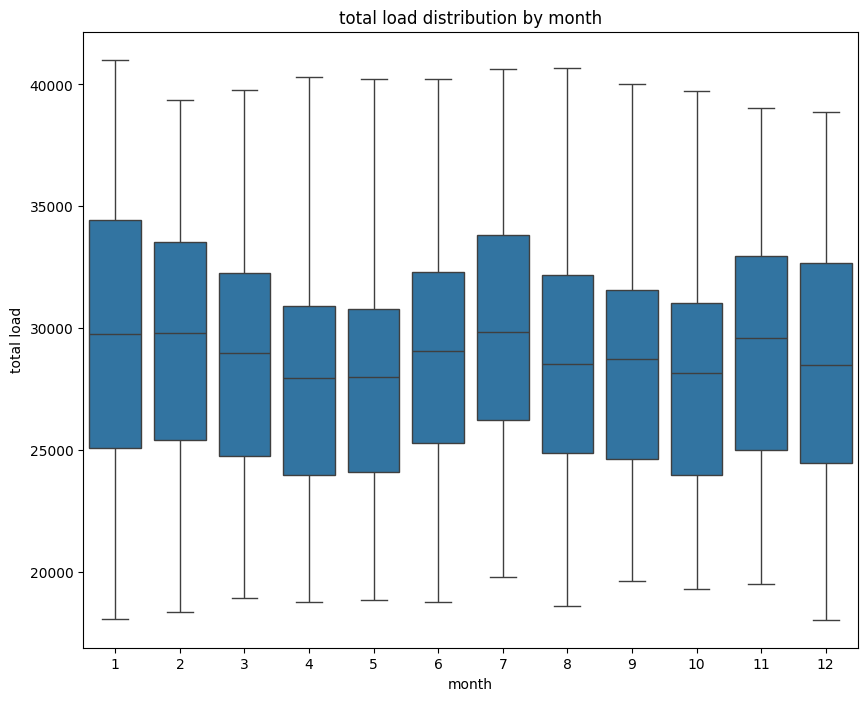

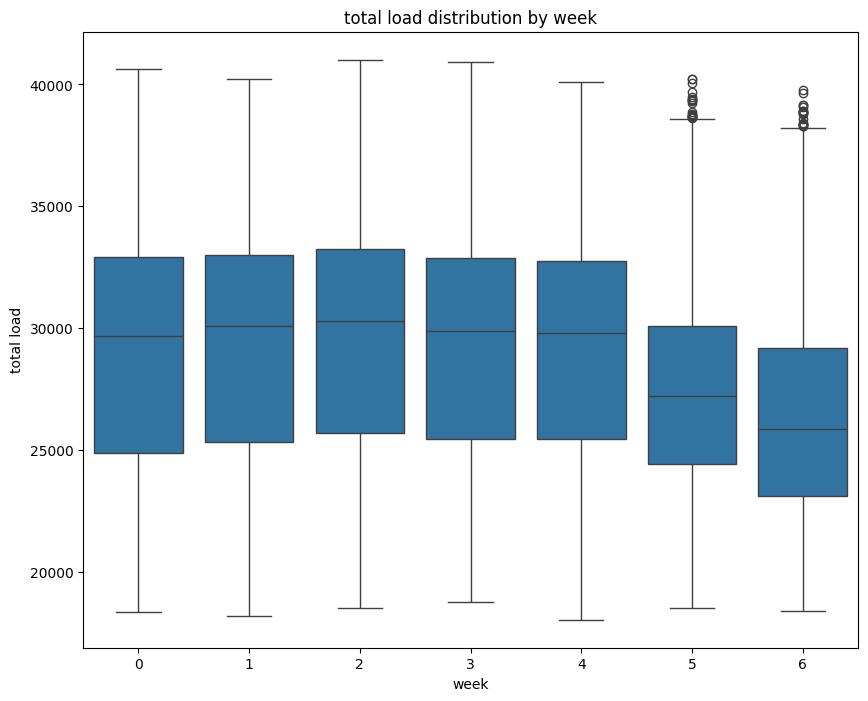

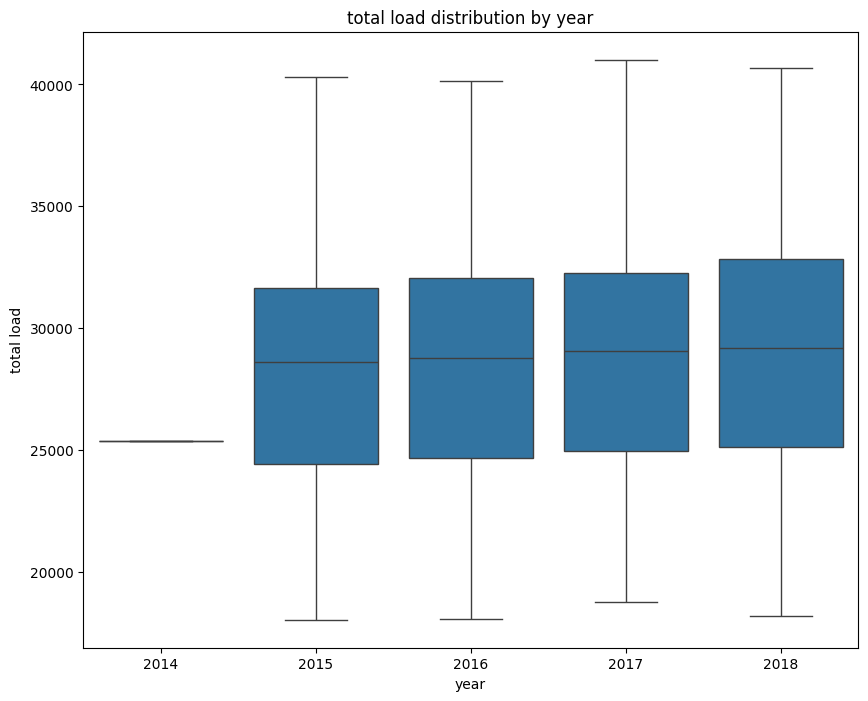

In [12]:

def boxplots(time_period):
    fig,axs = plt.subplots(figsize=(10,8))
    data = zip(df[time_period], df["total load actual"])
    for x in range(3):
        seaborn.boxplot(data = df,x = time_period,y = "total load actual", ax = axs)
        #axs.tick_params(axis='x', colors='white')
        #axs.tick_params(axis='y', colors='white')
        axs.set_ylabel("total load")
        axs.set_title(f"total load distribution by {time_period}")

        plt.show()

boxplots("month")
boxplots("week")
boxplots("year")

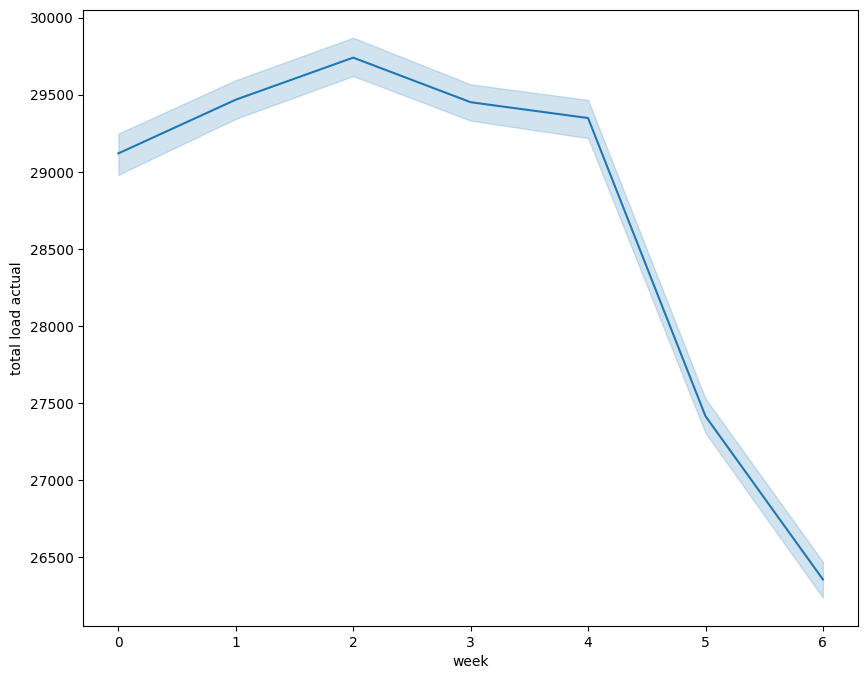

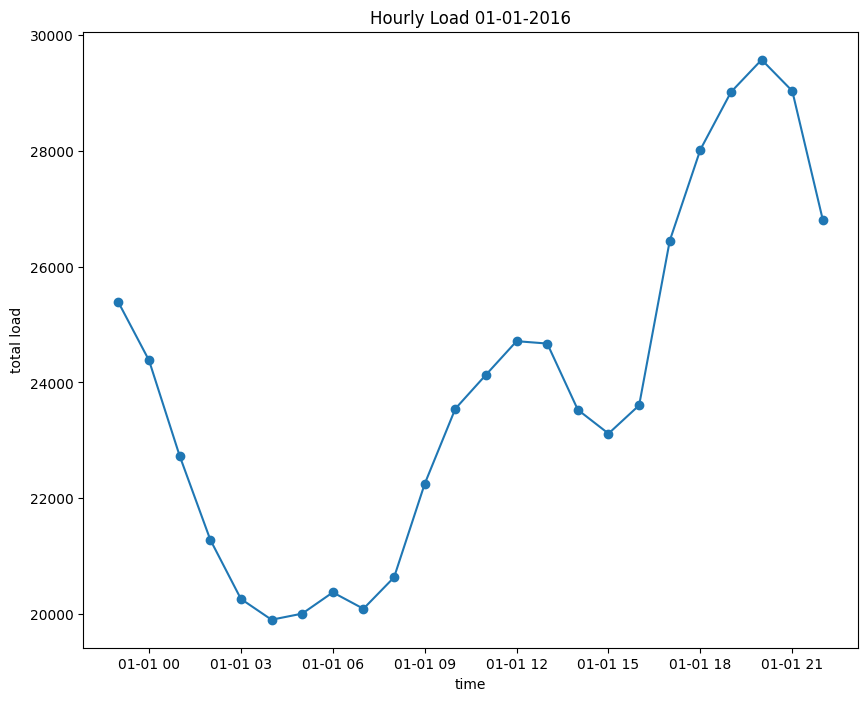

In [31]:
def feature_plot(data,feature):
    plt.figure(figsize=(8, 6))
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')
    plt.plot(data.index, data[feature])

def multi_plot(features):
    fig,axs = plt.subplots(len(features),figsize=(16,48))
    for x in range(len(features)):
        axs[x].plot(df.index, df[features[x]])
        axs[x].set_title(features[x],color = "white")
        axs[x].tick_params(axis='x', colors='white')
        axs[x].tick_params(axis='y', colors='white')
        
    fig.tight_layout()
def plot_season(time_period):
    fig,axs = plt.subplots(figsize=(10,8))
    data = zip(df[time_period], df["total load actual"])
    seaborn.lineplot(data = df,x = time_period,y = "total load actual", ax = axs)
    
#feature_plot(dfdaily,"total load actual")
#multi_plot(["generation biomass","generation fossil brown coal/lignite","generation fossil gas"])
plot_season("week")
fig,axs = plt.subplots(figsize=(10,8))
plt.plot(df.index[0:24],df["total load actual"].iloc[0:24],"o-")
plt.title("Hourly Load 01-01-2016")
plt.xlabel('time')
plt.ylabel('total load')
plt.show()

In [ ]:
#plot all features
fig = plt.figure(figsize=(30,18))
ax = fig.add_subplot(2, 1, 1)
for column in df:
    ax.plot(df.index, df[column])
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_yscale("log")
ax.legend()